# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [23]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, countDistinct
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType,StringType ,DoubleType

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.metrics import f1_score

from functools import reduce
from datetime import datetime
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

In [24]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spakify_Project_MKazi") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [25]:
# read JSON file into spark dataframe
df = spark.read.json("mini_sparkify_event_data.json")

In [26]:
# create a spark SQL view 
df.createOrReplaceTempView("df_table")


In [27]:
# removing all 'blank' users 
sql1 =  """
        SELECT DISTINCT * 
        FROM df_table 
        WHERE userID <> ''

        """

df = spark.sql(sql1)


In [28]:
# converting timestamps into date-time strings 
converttimestamp = udf(lambda ts: datetime.utcfromtimestamp(ts/1000).strftime('%Y-%m-%d %H:%M:%S'), StringType())

df = df.withColumn('DateTime',converttimestamp(col('ts')))
df = df.withColumn('RegistrationDate',converttimestamp(col('registration')))

In [29]:
# dropping unnecessary columns
columns_to_drop = ['firstName', 'lastName','method','status','auth','ts','registration']
df = df.drop(*columns_to_drop)

In [30]:
# remaking spark SQL view
df.createOrReplaceTempView("df_table")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [54]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- DateTime: string (nullable = true)
 |-- RegistrationDate: string (nullable = true)
 |-- Churn: integer (nullable = false)



In [31]:
# create 'Churn' column based on 'Cancellation Confirmation' event

sql2 =  """
        select distinct 
        
             a.*
            ,case when b.uid is not null then 1 else 0 end as Churn
        
        from df_table a
        
        left join ( select distinct userid as uid from df_table where page = 'Cancellation Confirmation') b
        on a.userid = b.uid
    
        """

df = spark.sql(sql2)


In [32]:
# remaking spark SQL view
df.createOrReplaceTempView("df_table")

In [33]:
# churn by level
df.groupBy(['churn','level']) \
  .agg(countDistinct(df.userId)) \
  .withColumnRenamed('count(DISTINCT userId)', 'UserCount') \
  .show(10)

    

+-----+-----+---------+
|churn|level|UserCount|
+-----+-----+---------+
|    0| free|      149|
|    0| paid|      129|
|    1| paid|       36|
|    1| free|       46|
+-----+-----+---------+



In [56]:
#  churn by gender
sql2 =  """
        select distinct 
        
         churn
        ,gender
        
        ,count(distinct userid) as UserCount
        


        from df_table a
        
        where 1=1
        
        group by churn
        ,gender
        
        order by churn
        
        limit 10
        
        """

spark.sql(sql2).show(4)

+-----+------+---------+
|churn|gender|UserCount|
+-----+------+---------+
|    0|     M|       89|
|    0|     F|       84|
|    1|     F|       20|
|    1|     M|       32|
+-----+------+---------+



In [55]:
#  churn by average time listened

sql2 =  """
        select distinct 
        
         churn
         ,avg(length) as AverageSessionLength

        
        from df_table a
        
        where 1=1
        
        group by churn
        
        
        order by churn
        
        limit 10
        
        
        """

spark.sql(sql2).show(2)

+-----+--------------------+
|churn|AverageSessionLength|
+-----+--------------------+
|    0|  249.20913538880816|
|    1|  248.63279564406218|
+-----+--------------------+



In [36]:
# Average number of events per group 


sql2 =  """

    select distinct 

            page, 
            churn,
            cast(count(page) / count(distinct userid) as int) as eventcount
        
        from df_table 
        
        where 1=1
        --and userid = 4
        
        group by 
            page, 
            churn
            
        order by page, churn     
            
"""

# creating a pandas dataframe from the results
event_df = spark.sql(sql2).toPandas()

In [37]:
# transforming the dataframe into a pivot table  
pvt = event_df.pivot_table(values=['eventcount'], 
                      index='page',
                      columns='churn',
                      aggfunc='sum')

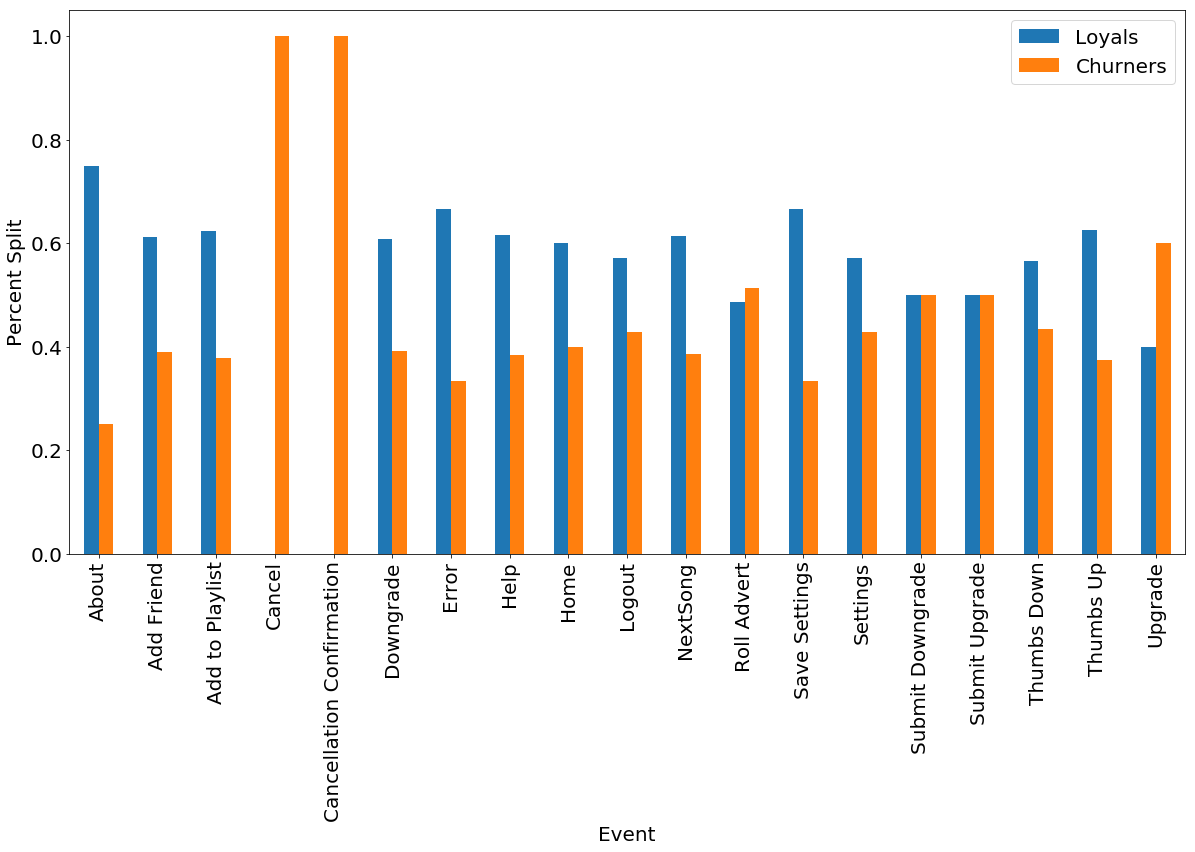

In [53]:
# plotting the pivot table
pvt = pvt.div(pvt.sum(1), axis=0)
ax = pvt.plot(kind='bar' ,stacked = False,figsize=(20,10),fontsize=20)
ax.legend(['Loyals','Churners'], fontsize=20)
ax.set_xlabel('Event', fontsize=20)
ax.set_ylabel('Percent Split', fontsize=20);
ax.plot();


In [39]:
# Churn by average days registered

sql2 =  """

select distinct 
    churn
    ,cast(AVG(DaysRegistered) as int) as AveDaysRegistered

from (
    select distinct 
            userid
            ,churn
            ,datediff(max(DateTime) , max(RegistrationDate)) as DaysRegistered

        from df_table 
        
        group by 
            userid
            ,churn

) A
group by churn


"""

spark.sql(sql2).show(10)

+-----+-----------------+
|churn|AveDaysRegistered|
+-----+-----------------+
|    1|               57|
|    0|               86|
+-----+-----------------+



In [40]:
#  churn by Variety of artists

sql2 =  """
select distinct 
    churn
    ,cast(AVG(NumberOfArtists) as int) as AveArtistsListenedTo

from (
    select distinct 
            userid
            ,churn
            ,count(distinct artist) as NumberOfArtists

        from df_table 

        group by 
            userid
            ,churn

) A
group by churn

        """

spark.sql(sql2).show(10)

+-----+--------------------+
|churn|AveArtistsListenedTo|
+-----+--------------------+
|    1|                 518|
|    0|                 749|
+-----+--------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [41]:
# adding features to dataset

sql2 =  """
        select distinct 
        
          userid
         ,gender
         ,churn
         
         ,count(distinct UserAgent) as NumberOfDevices
         ,avg(length) as AverageSongLength
         ,sum(length) as TotalSongLength
         ,count(distinct artist) as TotalArtists
         ,count(distinct song) as TotalSongs
         ,count(distinct sessionID) as TotalSessions
         ,sum(length) / count(distinct sessionID) as AveTimePerSession
         ,count(distinct artist) / count(distinct sessionID) as AveArtistsPerSession
         ,count(distinct song) / count(distinct sessionID) as AveSongsPerSession
         ,count(distinct page) / count(distinct sessionID) as AveEventsPerSession
         ,datediff(max(DateTime) , max(RegistrationDate)) as DaysRegistered
         
        from df_table a
        
        where 1=1
        
        group by           
          userid
         ,gender
         ,churn
        
        """

df1 = spark.sql(sql2)

In [42]:
#  adding even more features to dataset

sql2 =  """

        select distinct 
             userid
            ,sum(FreeSessions) FreeSessions
            ,sum(PaidSessions) PaidSessions
        from

        (
                select distinct 
                            userid

                         ,(case when level = 'free' then count(distinct sessionID) else 0 end) as FreeSessions
                         ,(case when level = 'paid' then count(distinct sessionID) else 0 end) as PaidSessions  

                from df_table

                group by userid, level
        ) A
        group by userid

        """

df2 = spark.sql(sql2)

In [43]:
# joining dataframes and then removing the component dataframes from memory 
df1 = df1.alias('df1')
df2 = df2.alias('df2')

df3 = df1.join(df2, df1.userid == df2.userid).select('df1.*','df2.FreeSessions','df2.PaidSessions')

df1.unpersist() 
df2.unpersist() 

DataFrame[userid: string, FreeSessions: bigint, PaidSessions: bigint]

In [44]:
# extracting events from original dataset to add as features 
sql = """

    select distinct
              userid as uid
             ,page
             ,count(sessionid) as EventCount
        
    from df_table
    where page not in ('Cancellation Confirmation','Cancel')
    group by 
         userid
        ,page

"""

df4 = spark.sql(sql)

In [45]:
# creating a pivot from the events dataframe above 
df4 = df4.groupBy("uid") \
          .pivot("page") \
          .agg(Fsum('EventCount'))

In [46]:
# joining dataframes and then removing the component dataframes from memory 
df3 = df3.alias('df3')
df4 = df4.alias('df4')

df5 = df3.join(df4, df3.userid == df4.uid).select('df3.*','df4.*')

df3.unpersist() 
df4.unpersist() 

DataFrame[uid: string, About: bigint, Add Friend: bigint, Add to Playlist: bigint, Downgrade: bigint, Error: bigint, Help: bigint, Home: bigint, Logout: bigint, NextSong: bigint, Roll Advert: bigint, Save Settings: bigint, Settings: bigint, Submit Downgrade: bigint, Submit Upgrade: bigint, Thumbs Down: bigint, Thumbs Up: bigint, Upgrade: bigint]

In [47]:
#  splitting the categorical gender column into two
Male = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
Female = udf(lambda x: 1 if x == 'F' else 0, IntegerType())

df5 = df5.withColumn('Male',Male(col('gender')) )
df5 = df5.withColumn('Female',Female(col('gender')) )


In [48]:
# dropping unnecessary columns
columns_to_drop = ['uid','gender']
df5 = df5.drop(*columns_to_drop)

In [49]:
# creating a dataframe copy to work with
df6 = df5

In [50]:
# replacing NULL values with '0' - vectors will not work with NULLs 
df6 = df6.na.fill(0)

In [51]:
# replacing spaces in column names
oldColumns = df5.schema.names
newColumns = [x.replace(' ','') for x in oldColumns]

df6 = reduce(lambda df6, idx: df6.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df6)



In [52]:
# setting the columns needed for scaling 
columns_to_scale = df6.schema.names[2:]

In [ ]:
# converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# iterating over columns to be scaled
for i in columns_to_scale:

    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df6 = pipeline.fit(df6).transform(df6).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")


In [ ]:
# saving results as a csv file to prevent redo-ing the scaling
# df6.toPandas().to_csv('ScaledData.csv')

In [ ]:
df6.schema.names

In [ ]:
# dropping unnecessary columns
columns_to_drop = ['userid',
                     'NumberOfDevices',
                     'AverageSongLength',
                     'TotalSongLength',
                     'TotalArtists',
                     'TotalSongs',
                     'TotalSessions',
                     'AveTimePerSession',
                     'AveArtistsPerSession',
                     'AveSongsPerSession',
                     'AveEventsPerSession',
                     'DaysRegistered',
                     'FreeSessions',
                     'PaidSessions',
                     'About',
                     'AddFriend',
                     'AddtoPlaylist',
                     'Downgrade',
                     'Error',
                     'Help',
                     'Home',
                     'Logout',
                     'NextSong',
                     'RollAdvert',
                     'SaveSettings',
                     'Settings',
                     'SubmitDowngrade',
                     'SubmitUpgrade',
                     'ThumbsDown',
                     'ThumbsUp',
                     'Upgrade',
                     'Male',
                     'Female']

df7 = df6.drop(*columns_to_drop)

In [ ]:
# # dropping unnecessary columns
# columns_to_drop = ['userid']

# df7 = df6.drop(*columns_to_drop)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [3]:
# read JSON file into spark dataframe
df7 = spark.read.csv("ScaledData.csv",inferSchema =True,header=True)

# here we omit the userid, churn, and non-scaled columns
feature_columns = df7.columns[35:]

assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")


df8 = assembler.transform(df7)

df9 = df8[['churn','features']]
df9 = df9.withColumnRenamed('churn','label')

In [4]:
# split our data into training, testing, and validation sets

train, rest = df9.randomSplit([0.8, 0.2], seed=42)
test, validation = rest.randomSplit([0.5, 0.5], seed=42)

## Random Forest

In [5]:
# create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# train model with Training Data
rfModel = rf.fit(train)

# make predictions on test data using the Transformer.transform() method.
predictions = rfModel.transform(test)

# show predictions
predictions.show()

# calculate the f1 score
f1_score(predictions.select('label').toPandas().label,predictions.select('prediction').toPandas().prediction)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.5,0.247,0.016,...|[12.1725908456934...|[0.60862954228467...|       0.0|
|    0|[0.5,0.508,0.026,...|[13.7281551246445...|[0.68640775623222...|       0.0|
|    0|[0.5,0.508,0.473,...|[19.3969396652732...|[0.96984698326366...|       0.0|
|    0|[0.5,0.511,0.043,...|[15.0569252364716...|[0.75284626182358...|       0.0|
|    0|[0.5,0.531,0.153,...|[18.8851235692195...|[0.94425617846097...|       0.0|
|    0|[0.5,0.544,0.334,...|[18.4474493965058...|[0.92237246982529...|       0.0|
|    0|[0.5,0.553,0.246,...|[16.2177058059323...|[0.81088529029661...|       0.0|
|    0|[0.5,0.567,0.37,0...|[14.4593538395637...|[0.72296769197818...|       0.0|
|    0|[0.5,0.597,0.204,...|[16.7687205901164...|[0.83843602950582...|       0.0|
|    0|[0.5,0.62

0.0

We can conclude that a Random Forest model is not ideal in this scenario.

## Gradient Boost Classifier

In [17]:
# train model
gbt = GBTClassifier(maxIter=20, 
                    maxDepth=3, 
                    stepSize=0.1,
                    labelCol="label", 
                    seed=42)

model = gbt.fit(train)

# get predictions
predictions = model.transform(test)

# show predictions
predictions.show()

# calculate the f1 score
f1_score(predictions.select('label').toPandas().label,predictions.select('prediction').toPandas().prediction)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.5,0.247,0.016,...|[0.68132910678267...|[0.79619138742330...|       0.0|
|    0|[0.5,0.508,0.026,...|[0.34138436790893...|[0.66435637013592...|       0.0|
|    0|[0.5,0.508,0.473,...|[1.26628205766399...|[0.92639338830662...|       0.0|
|    0|[0.5,0.511,0.043,...|[0.58227113933548...|[0.76215709056316...|       0.0|
|    0|[0.5,0.531,0.153,...|[1.39760439050238...|[0.94241636585584...|       0.0|
|    0|[0.5,0.544,0.334,...|[1.34408301063248...|[0.93632472596567...|       0.0|
|    0|[0.5,0.553,0.246,...|[1.25025813261783...|[0.92417800416645...|       0.0|
|    0|[0.5,0.567,0.37,0...|[0.64041716492939...|[0.78259176435503...|       0.0|
|    0|[0.5,0.597,0.204,...|[0.86235420294667...|[0.84873431516979...|       0.0|
|    0|[0.5,0.62

0.40000000000000002

The above results are quite promising for a Gradient Boosted model.

## MultiLayer Perceptron

In [20]:

# specify layers for the neural network:
# input layer of size 32 (features), two intermediate of size 5 and 4
# and output of size 2 (classes)
layers = [32, 5, 4, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=50, layers=layers, blockSize=128, seed=42)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
predictions = model.transform(test)

# show predictions
predictions.show()

# calculate the f1 score
f1_score(predictions.select('label').toPandas().label,predictions.select('prediction').toPandas().prediction)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.5,0.247,0.016,...|[-0.1917144206703...|[0.78441828712558...|       0.0|
|    0|[0.5,0.508,0.026,...|[-0.1915941136641...|[0.78445973917430...|       0.0|
|    0|[0.5,0.508,0.473,...|[0.17739719816426...|[0.88808807092479...|       0.0|
|    0|[0.5,0.511,0.043,...|[-0.1913998823484...|[0.78452670444617...|       0.0|
|    0|[0.5,0.531,0.153,...|[-0.1930438248476...|[0.78394926570441...|       0.0|
|    0|[0.5,0.544,0.334,...|[0.49464243021000...|[0.93949568009943...|       0.0|
|    0|[0.5,0.553,0.246,...|[0.53016472698392...|[0.94356936119110...|       0.0|
|    0|[0.5,0.567,0.37,0...|[-6.8111396143552...|[3.06082199995687...|       1.0|
|    0|[0.5,0.597,0.204,...|[0.35317009932601...|[0.92003445073937...|       0.0|
|    0|[0.5,0.62

0.28571428571428575

The Perceptron does outperform the Random Forest, but does not perform better than the Grandient Boosted model.

## Performance Tuning

It would appear that the GBT model has the best F1 score and this is quite evident from the predictions.
<br>
Other models may outperform the GBT with a higher sample size however.

We can now attempt to tune the model for better performance. We will do this witha  combination of parameter grid searching and cross validation.

<br>
Since we do not have a lot of processing power or time, we'll keep the parameter grid small, and the number of crossvalidations low. 

In [21]:
#  setup parameter grid
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(maxDepth=3, 
                    stepSize=0.1,
                    labelCol="label", 
                    seed=42)

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxIter, [10, 50, 100])
             .build())

evaluator = BinaryClassificationEvaluator()

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# train model on multiple parameters 
cvModel = cv.fit(train)

predictions = cvModel.transform(test)

# calculate the f1 score
f1_score(predictions.select('label').toPandas().label,predictions.select('prediction').toPandas().prediction)

0.66666666666666663

With the above we can see that we've possibly reached a limit in what we can extract from this small dataset, and limited computing power. 
<br>

Let's apply the best model to our validation set.


In [22]:
# find the best parameters from the cross validation and parameter grid 
bestModel = cvModel.bestModel

# make predictions on the validation set
finalPredictions = bestModel.transform(validation)

# calculate the f1 score
f1_score(finalPredictions.select('label').toPandas().label,finalPredictions.select('prediction').toPandas().prediction)


0.57142857142857151

We do see a roughly 10% drop in our f1 score. 

While not ideal, this is an acceptable level for our purposes. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.